In [1]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import fastreg.linear as frl
import fastreg.general as frg
import fastreg.testing as frt
%matplotlib inline

### Generate Data

In [86]:
data = frt.dataset(N=500_000, K1=10, K2=100, seed=89320432)
data.head()

,id1,id2,x1,x2,yhat0,yhat,y0,y,Eb0,Eb,...,Ep0,Ep,p0,p,pz0,pz,nb0,nb,nbz0,nbz
0,4,31,1.179880,1.303179,1.235872,1.945872,2.043018,4.503822,0.774845,0.874996,...,3.441377,6.999731,8,3,0,3,1,7,1,7
1,8,36,-1.425219,1.159942,0.368399,1.528399,-0.133417,2.520287,0.591072,0.821772,...,1.445419,4.610790,1,10,1,0,2,11,0,11
2,8,87,-0.149973,-0.430441,-0.203256,1.466744,-0.553961,1.415974,0.449360,0.812562,...,0.816069,4.335095,2,3,2,0,0,2,0,2
3,8,31,-1.435251,-1.390140,-1.164659,-0.054659,-1.060727,0.062333,0.237822,0.486339,...,0.312029,0.946808,0,0,0,0,0,2,0,2
4,6,57,0.430889,3.103699,2.091486,3.261486,2.177262,2.688953,0.890073,0.963084,...,8.096939,26.088278,4,25,4,0,11,38,11,0


### Normal OLS

In [87]:
%time smf.ols('y0 ~ x1 + x2', data=data).fit().params

CPU times: user 332 ms, sys: 225 ms, total: 557 ms
Wall time: 147 ms


Intercept    0.098888
x1           0.299801
x2           0.599727
dtype: float64

In [88]:
%time frl.ols(y='y0', x=['x1', 'x2'], data=data)

CPU times: user 48 ms, sys: 30.6 ms, total: 78.6 ms
Wall time: 34 ms


,coeff,stderr,low95,high95,pvalue
one,0.098888,0.001416,0.096114,0.101662,0.0
x1,0.299801,0.001416,0.297026,0.302576,0.0
x2,0.599727,0.001414,0.596955,0.602500,0.0


### Sparse OLS

In [89]:
%time frl.ols(y='y', x=['x1', 'x2'], fe=['id1', 'id2'], data=data)

CPU times: user 565 ms, sys: 45.8 ms, total: 611 ms
Wall time: 563 ms


,coeff,stderr,low95,high95,pvalue
one,0.119351,0.014622,0.090693,0.148009,2.220446e-16
x1,0.298718,0.001414,0.295947,0.301488,0.000000e+00
x2,0.602568,0.001412,0.599800,0.605336,0.000000e+00
i=1,0.098538,0.006326,0.086140,0.110936,0.000000e+00
i=2,0.196159,0.006317,0.183777,0.208541,0.000000e+00
...,...,...,...,...,...
i=95,0.924802,0.019849,0.885898,0.963705,0.000000e+00
i=96,0.942108,0.019977,0.902954,0.981263,0.000000e+00
i=97,0.958001,0.019908,0.918983,0.997019,0.000000e+00
i=98,0.964065,0.019887,0.925088,1.003042,0.000000e+00


In [90]:
%time frl.ols(y='y', x=['x1', 'x2'], absorb=('id1', 'id2'), data=data)

CPU times: user 759 ms, sys: 415 ms, total: 1.17 s
Wall time: 401 ms


,coeff,stderr,low95,high95,pvalue
one,1.044704,0.001307,1.042143,1.047265,0.0
x1,0.298718,0.001497,0.295784,0.301651,0.0
x2,0.602568,0.001458,0.599709,0.605426,0.0


### Poisson

In [125]:
%time beta, sigma = frg.poisson(y='p0', x=['x1', 'x2'], data=data)

[  0] -0.8983: 0.1276 0.0012
[  1] -0.7575: 0.2407 0.0059
[  2] -0.6801: 0.2961 0.0590
CPU times: user 2.1 s, sys: 457 ms, total: 2.55 s
Wall time: 1.69 s


In [126]:
np.sqrt(np.diag(sigma['beta']['beta']))

array([0.00132492, 0.00119769, 0.001197  ], dtype=float32)

In [127]:
%time beta, sigma = frg.poisson(y='p', x=['x1', 'x2'], fe=['id1', 'id2'], data=data, epochs=10)

[  0] -0.2275: 0.1249 0.0029
[  1] 0.9754: 0.2363 0.0095
[  2] 1.8342: 0.3178 0.0538
[  3] 2.2878: 0.3355 0.1338
[  4] 2.4718: 0.3156 0.2052
[  5] 2.5218: 0.3036 0.2538
[  6] 2.5312: 0.3007 0.2751
[  7] 2.5331: 0.3010 0.2817
[  8] 2.5338: 0.3020 0.2839
[  9] 2.5342: 0.3033 0.2849
CPU times: user 7.93 s, sys: 1.58 s, total: 9.51 s
Wall time: 6.53 s


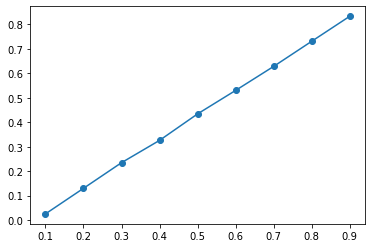

In [129]:
plt.plot(np.arange(1, 10)/10, beta['beta'][3:12], marker='o');

### Ultra Wide

In [33]:
N = 2_000_000
df = pd.DataFrame({ 
    'x1': np.random.rand(N), 
    'x2': np.random.rand(N), 
    'id1': np.ceil(np.arange(N)/200+1e-7).astype(np.int), 
    'id2': np.random.randint(1, 10001, size=N) 
})
df['y'] = df['x1'] + 2*df['x2'] + np.log(df['id1']) + np.log10(df['id2']) + np.random.randn(N)

In [39]:
%time frl.ols(y='y', x=['x1', 'x2'], absorb=['id1', 'id2'], data=df)

CPU times: user 4.39 s, sys: 2.18 s, total: 6.57 s
Wall time: 5.7 s


,coeff,stderr,low95,high95,pvalue
one,11.775893,0.001870,11.772228,11.779559,0.0
x1,1.000463,0.002449,0.995662,1.005264,0.0
x2,2.001758,0.002451,1.996954,2.006562,0.0
